### Project title:

### Introduction:

### Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(readxl)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [37]:
# reding the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data

# select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

training_data

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [38]:
# summarize the training data, counting how many occurences of each class 
num_of_class <- training_data %>%
    count(UNS)

num_of_class

UNS,n
<fct>,<int>
very_low,24
High,63
Low,83
Middle,88


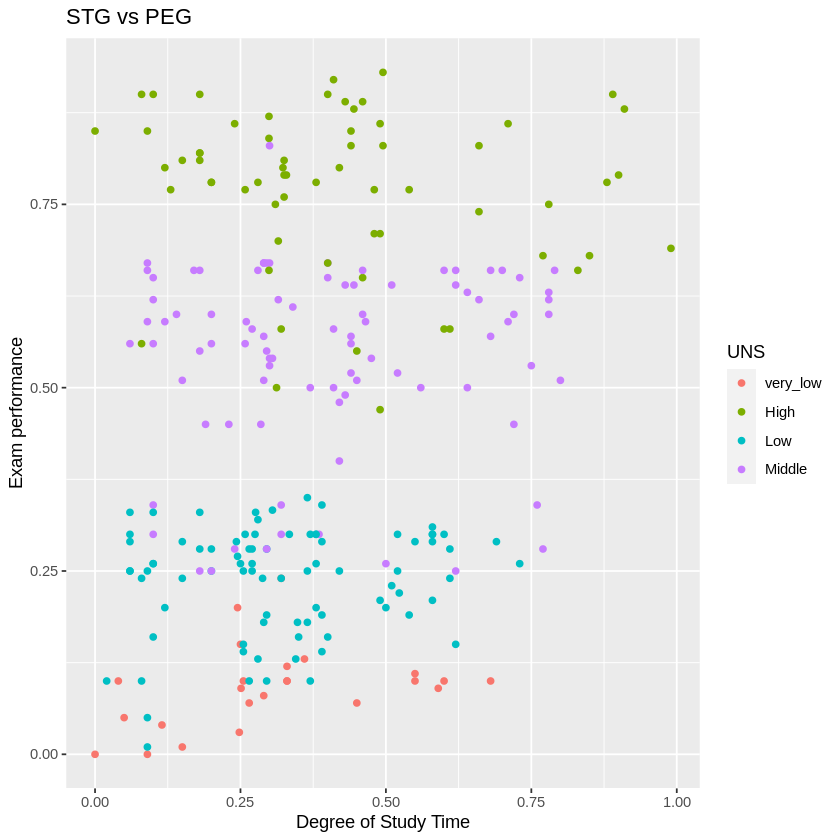

In [41]:
# plot STG vs PEG and coloring the class of UNS
# STG => The degree of study time for goal object materails
# PEG => The exam performance of user for goal objects

plot <- training_data %>%
    ggplot(aes(x = STG, y = PEG, color = UNS)) +
    geom_point() +
    xlab('Degree of Study Time') +
    ylab('Exam performance') +
    ggtitle('STG vs PEG')

plot

### Methods:

### Expected outcomes and significance: